# NPS - 5HT2a - Machine learning 

## Setup
### Library

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
import pickle

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,  ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.SimDivFilters import MaxMinPicker
from rdkit.Chem import Draw
import math

from molvs import standardize_smiles
from collections import defaultdict

from matplotlib import colors as plt_colors
import shap

from rdkit.Chem.Draw.SimilarityMaps import GetSimilarityMapForModel
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import SimilarityMaps
from tqdm.notebook import tqdm

from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from functools import partial
import io
from PIL import Image

import random


### Functions

In [ ]:

def diversity_train_test_split(df, strat_size=0.8, outcome='y', lable_encode=False):
    
    mfpgen = GetMorganGenerator(radius=2, fpSize=2048)
    mmp = MaxMinPicker()

    selected_indices = []

    for label in df[outcome].unique():
        df_sub = df[df[outcome] == label].copy()
        
        fps = []
        mol_list = []
        idx_list = []

        for idx, row in df_sub.iterrows():
            mol = Chem.MolFromSmiles(row['smiles'])
            if mol is None:
                continue
            fp = mfpgen.GetFingerprint(mol)
            fps.append(fp)
            mol_list.append(mol)
            idx_list.append(idx)

        n_total = len(fps)
        n_pick = math.floor(strat_size * n_total)

        if n_total >= n_pick and n_pick > 0:
            idx_list = list(df_sub.index) 
            bv_ids = mmp.LazyBitVectorPick(fps, len(fps), n_pick)
            selected_indices.extend([idx_list[i] for i in bv_ids])

    selected_indices = list(selected_indices)

    remaining_indices = list(set(df.index) - set(selected_indices))

    X_train = df.loc[selected_indices].drop([outcome, 'smiles'], axis=1).copy()
    X_test = df.loc[remaining_indices].drop([outcome, 'smiles'], axis=1).copy()
    y_train = df.loc[selected_indices][outcome].copy()
    y_test = df.loc[remaining_indices][outcome].copy()
    
    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train=le.transform(y_train)
    y_test=le.transform(y_test)
    
    if lable_encode:
        return X_train, X_test, y_train, y_test, le
    else:
        return X_train, X_test, y_train, y_test


def my_diverse_xgboost(df_orig, model, my_index):

    df = df_orig.copy()
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)

    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_train)
    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = xgb_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted")    

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train,
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',  
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])  
    
    return df_result

def my_diverse_xgboost_model(df_orig):
    
    df = df_orig.copy()   
    
    X_train, X_test, y_train, y_test = diversity_train_test_split(df, strat_size=0.8)
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, num_class=len(label_encoder.classes_))
    xgb_model.fit(X_train, y_train_encoded)
    
    
    return xgb_model, X_train, X_test, y_train_encoded, y_test_encoded, label_encoder

def my_diverse_random_forest(df_orig, model, my_index):

    df = df_orig.copy()   
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    rf = RandomForestClassifier(class_weight=class_weight)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_train)
    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = rf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted")

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train, 
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',   
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])   
    
    return df_result

def my_diverse_svm(df_orig, model, my_index, scale=False):

    df = df_orig.copy()
    
    df = df.dropna(axis=0) 
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    if scale:
      scaler = preprocessing.StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    mysvm = svm.SVC(decision_function_shape='ovo', class_weight=class_weight, probability=True)
    mysvm.fit(X_train, y_train)
    
    y_pred = mysvm.predict(X_train)
    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = mysvm.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted") 
    
    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train,
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',  
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])  
    
    return df_result

def my_diverse_mlp(df_orig, model, my_index, scale=False):

    df = df_orig.copy()
    df = df.dropna(axis=0) 
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    if scale:
      scaler = preprocessing.StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
       
    params = {'hidden_layer_sizes' : [10,10],
          'activation' : 'relu', 'solver' : 'adam',
          'alpha' : 0.0, 'batch_size' : 10,
          'random_state' : 1,'tol' : 0.0001,
          'nesterovs_momentum' : False,
          'learning_rate' : 'constant',
          'learning_rate_init' : 0.01,
          'max_iter' : 1000, 'shuffle' : True,
          'n_iter_no_change' : 90, 'verbose' : False }

    net = MLPClassifier(**params)
    
    net.fit(X_train, y_train)
    
    y_pred = net.predict(X_train)
    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = net.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted") 

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train, 
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',  
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])  
    
    return df_result

def my_diverse_lr(df_orig, model, my_index, scale=False):

    df = df_orig.copy()
    df = df.dropna(axis=0) 
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    if scale:
      scaler = preprocessing.StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    lr = LogisticRegression(solver='lbfgs', class_weight=class_weight, random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)
   
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = lr.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted") 

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train, # roc_train, # 
                           f1_test, precision_test, recall_test #roc_test, #
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',   #'roc_train',
                                  'f1_test', 'precision_test', 'recall_test'#'roc_test',
                                  ],
                         index=[my_index])  
    
    return df_result


def shuffle(x):
    x = list(x)
    random.shuffle(x)
    return x


def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

def get_pred(fp, model_predict):
    pred = model_predict([fp])[0]
    return float(pred)

fpfunc = partial(SimilarityMaps.GetMorganFingerprint, radius=3, nBits=2048) #, fpType='bv')


def single_prediction(mol, model_predict):
    fp = fpfunc(mol)
    pred = model_predict([fp])[0]
    return float(pred)
    

def crop_to_content(png_bytes, pad=15, white_threshold=250):

    img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
    arr = np.asarray(img)
    alpha = arr[:, :, 3]
    rgb = arr[:, :, :3]

    content_mask = (alpha > 0) & (np.any(rgb < white_threshold, axis=2))

    if not content_mask.any():
        return img  

    ys, xs = np.where(content_mask)
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()

    x0 = max(x0 - pad, 0)
    y0 = max(y0 - pad, 0)
    x1 = min(x1 + pad, img.width - 1)
    y1 = min(y1 + pad, img.height - 1)

    return img.crop((x0, y0, x1 + 1, y1 + 1))


def plot_similarity_map(mol, model, size=(400,400)):
    d = Draw.MolDraw2DCairo(*size)
    SimilarityMaps.GetSimilarityMapForModel(
        mol,
        fpfunc, 
        lambda x: get_pred(x, model.predict),
        draw2d=d
    )
    d.FinishDrawing()
    png = d.GetDrawingText()
    img = crop_to_content(png, pad=12)
    return img

## Import datasets

In [ ]:

with open("ki_dataframes.pkl", "rb") as f:
    loaded = pickle.load(f)

df_kr = loaded["df_kr"]
df_maccs = loaded["df_maccs"]
df_ecfp = loaded["df_ecfp"]
df_ki = loaded["df_ki"]

## Model training

### XGBoost

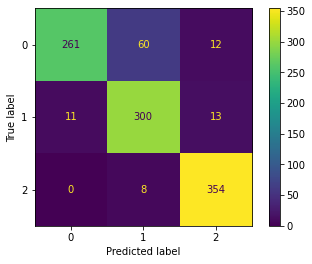

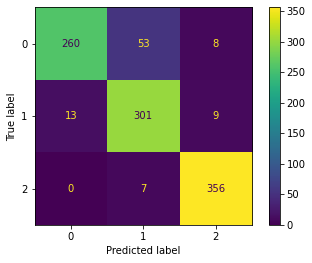

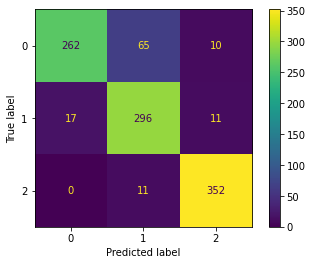

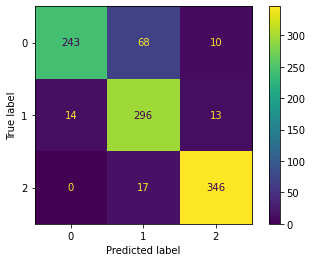

In [8]:
df_1 = my_diverse_xgboost(df_ki, 'padel', 'XGBoost')
df_2 = my_diverse_xgboost(df_ecfp, 'ecfp', 'XGBoost')
df_3 = my_diverse_xgboost(df_maccs, 'maccs', 'XGBoost')
df_4 = my_diverse_xgboost(df_kr, 'KlekotaRoth', 'XGBoost')

df_final_xgb = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Random Forest

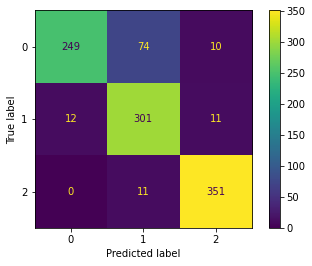

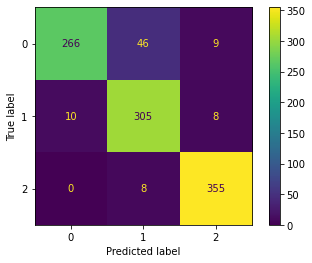

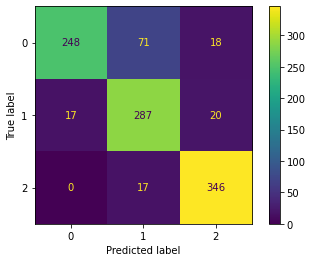

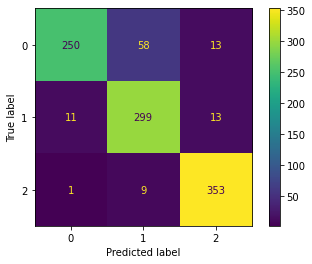

In [9]:
df_1 = my_diverse_random_forest(df_ki, 'padel', 'RandomForest')
df_2 = my_diverse_random_forest(df_ecfp, 'ecfp', 'RandomForest')
df_3 = my_diverse_random_forest(df_maccs, 'maccs', 'RandomForest')
df_4 = my_diverse_random_forest(df_kr, 'KlekotaRoth', 'RandomForest')

df_final_rf = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### SVM

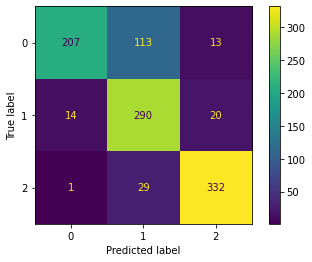

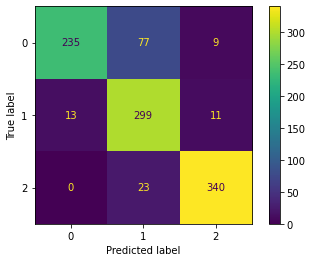

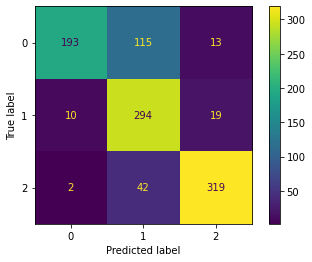

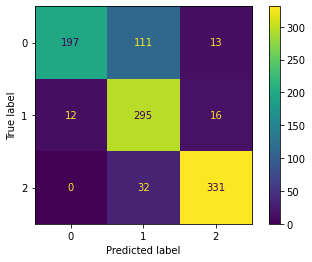

In [10]:
df_1 = my_diverse_svm(df_ki, 'padel', 'SVM', scale=True)
df_2 = my_diverse_svm(df_ecfp, 'ecfp', 'SVM')
df_3 = my_diverse_svm(df_maccs, 'maccs', 'SVM')
df_4 = my_diverse_svm(df_kr, 'KlekotaRoth', 'SVM')

df_final_svm = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Multi-layer Perceptron

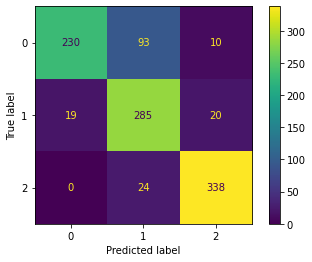

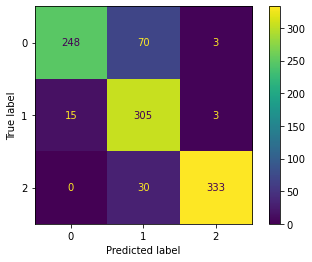

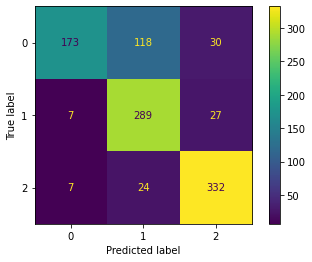

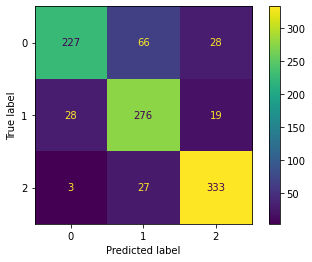

In [11]:
df_1 = my_diverse_mlp(df_ki, 'padel', 'MLP', scale=True)
df_2 = my_diverse_mlp(df_ecfp, 'ecfp', 'MLP')
df_3 = my_diverse_mlp(df_maccs, 'maccs', 'MLP')
df_4 = my_diverse_mlp(df_kr, 'KlekotaRoth', 'MLP')

df_final_mlp = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Logistic regression

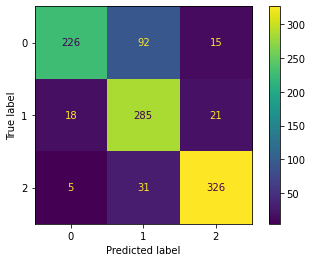

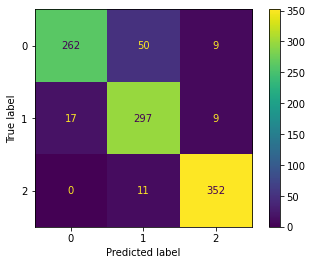

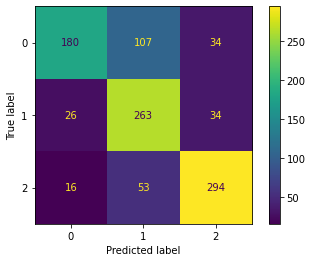

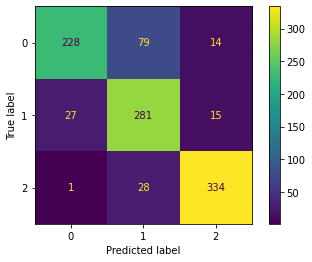

In [12]:
df_1 = my_diverse_lr(df_ki, 'padel', 'LR', scale=True)
df_2 = my_diverse_lr(df_ecfp, 'ecfp', 'LR')
df_3 = my_diverse_lr(df_maccs, 'maccs', 'LR')
df_4 = my_diverse_lr(df_kr, 'KlekotaRoth', 'LR')

df_final_lr = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Combine outcome and save

In [13]:
df_final_models = pd.concat([df_final_xgb, df_final_rf, df_final_svm, df_final_mlp, df_final_lr])

# df_final_models.to_excel('ML_model_comparison_outcome_13.xlsx', index= True)

## y-randomization

In [14]:
# ki
df_ki_rand = df_ki
df_ki_rand['y'] = shuffle(df_ki["y"])

# maccs
df_maccs_rand = df_maccs
df_maccs_rand['y'] = shuffle(df_maccs["y"])

# ecfp
df_ecfp_rand = df_ecfp
df_ecfp_rand['y'] = shuffle(df_ecfp["y"])

# kr
df_kr_rand = df_kr
df_kr_rand['y'] = shuffle(df_kr["y"])

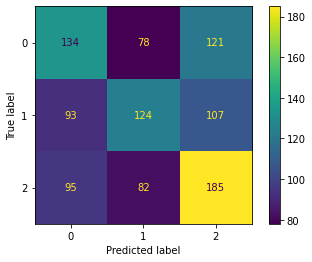

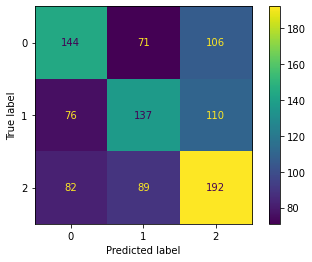

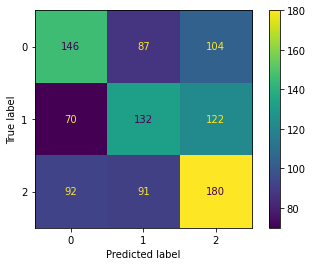

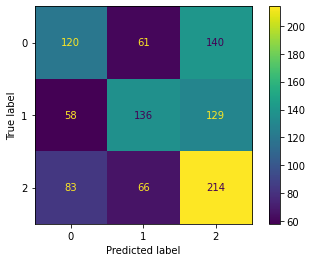

In [15]:
df_1 = my_diverse_xgboost(df_ki_rand, 'padel', 'XGBoost')
df_2 = my_diverse_xgboost(df_ecfp_rand, 'ecfp', 'XGBoost')
df_3 = my_diverse_xgboost(df_maccs_rand, 'maccs', 'XGBoost')
df_4 = my_diverse_xgboost(df_kr_rand, 'KlekotaRoth', 'XGBoost')

df_final_xgb = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

## SHAP values XGBoost

### Molecular descriptors - diversity

In [16]:
model, X_train, X_test, y_train, y_test, label_encoder = my_diverse_xgboost_model(df_ki)

In [ ]:

# load
with open("model_padel_xgb_div.pkl", "rb") as f:
    loaded = pickle.load(f)

model = loaded["model"]
X_train = loaded["X_train"]
X_test = loaded["X_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
label_encoder = loaded["label_encoder"]

In [18]:
explainer = shap.Explainer(model, X_train, algorithm="tree")
shap_values = explainer(X_test)

 99%|===================| 3032/3057 [00:42<00:00]        

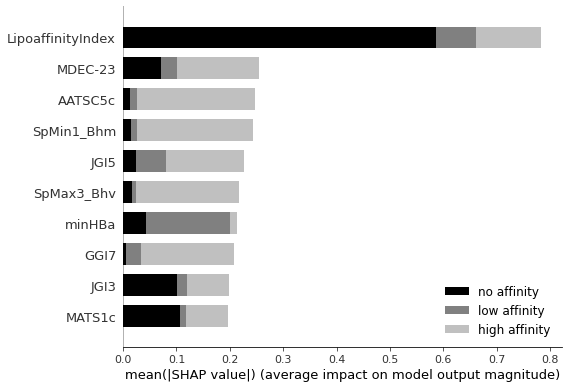

In [ ]:
colors = ["silver", "gray", "black"]
classes = ["no affinity", "low affinity", "high affinity"]

class_inds = np.argsort(classes)

cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

shap.summary_plot(shap_values, X_test.values, max_display=10, class_names=["no affinity", "low affinity", "high affinity"], class_inds=[0, 1, 2], plot_type="bar", 
                  color = cmap, show=False)

# plt.savefig('summary_plot_shap.png', bbox_inches='tight', dpi=300)

In [20]:
shap_values_class0 = shap_values[:, :, 0]  
shap_values_class1 = shap_values[:, :, 1]  
shap_values_class2 = shap_values[:, :, 2]  

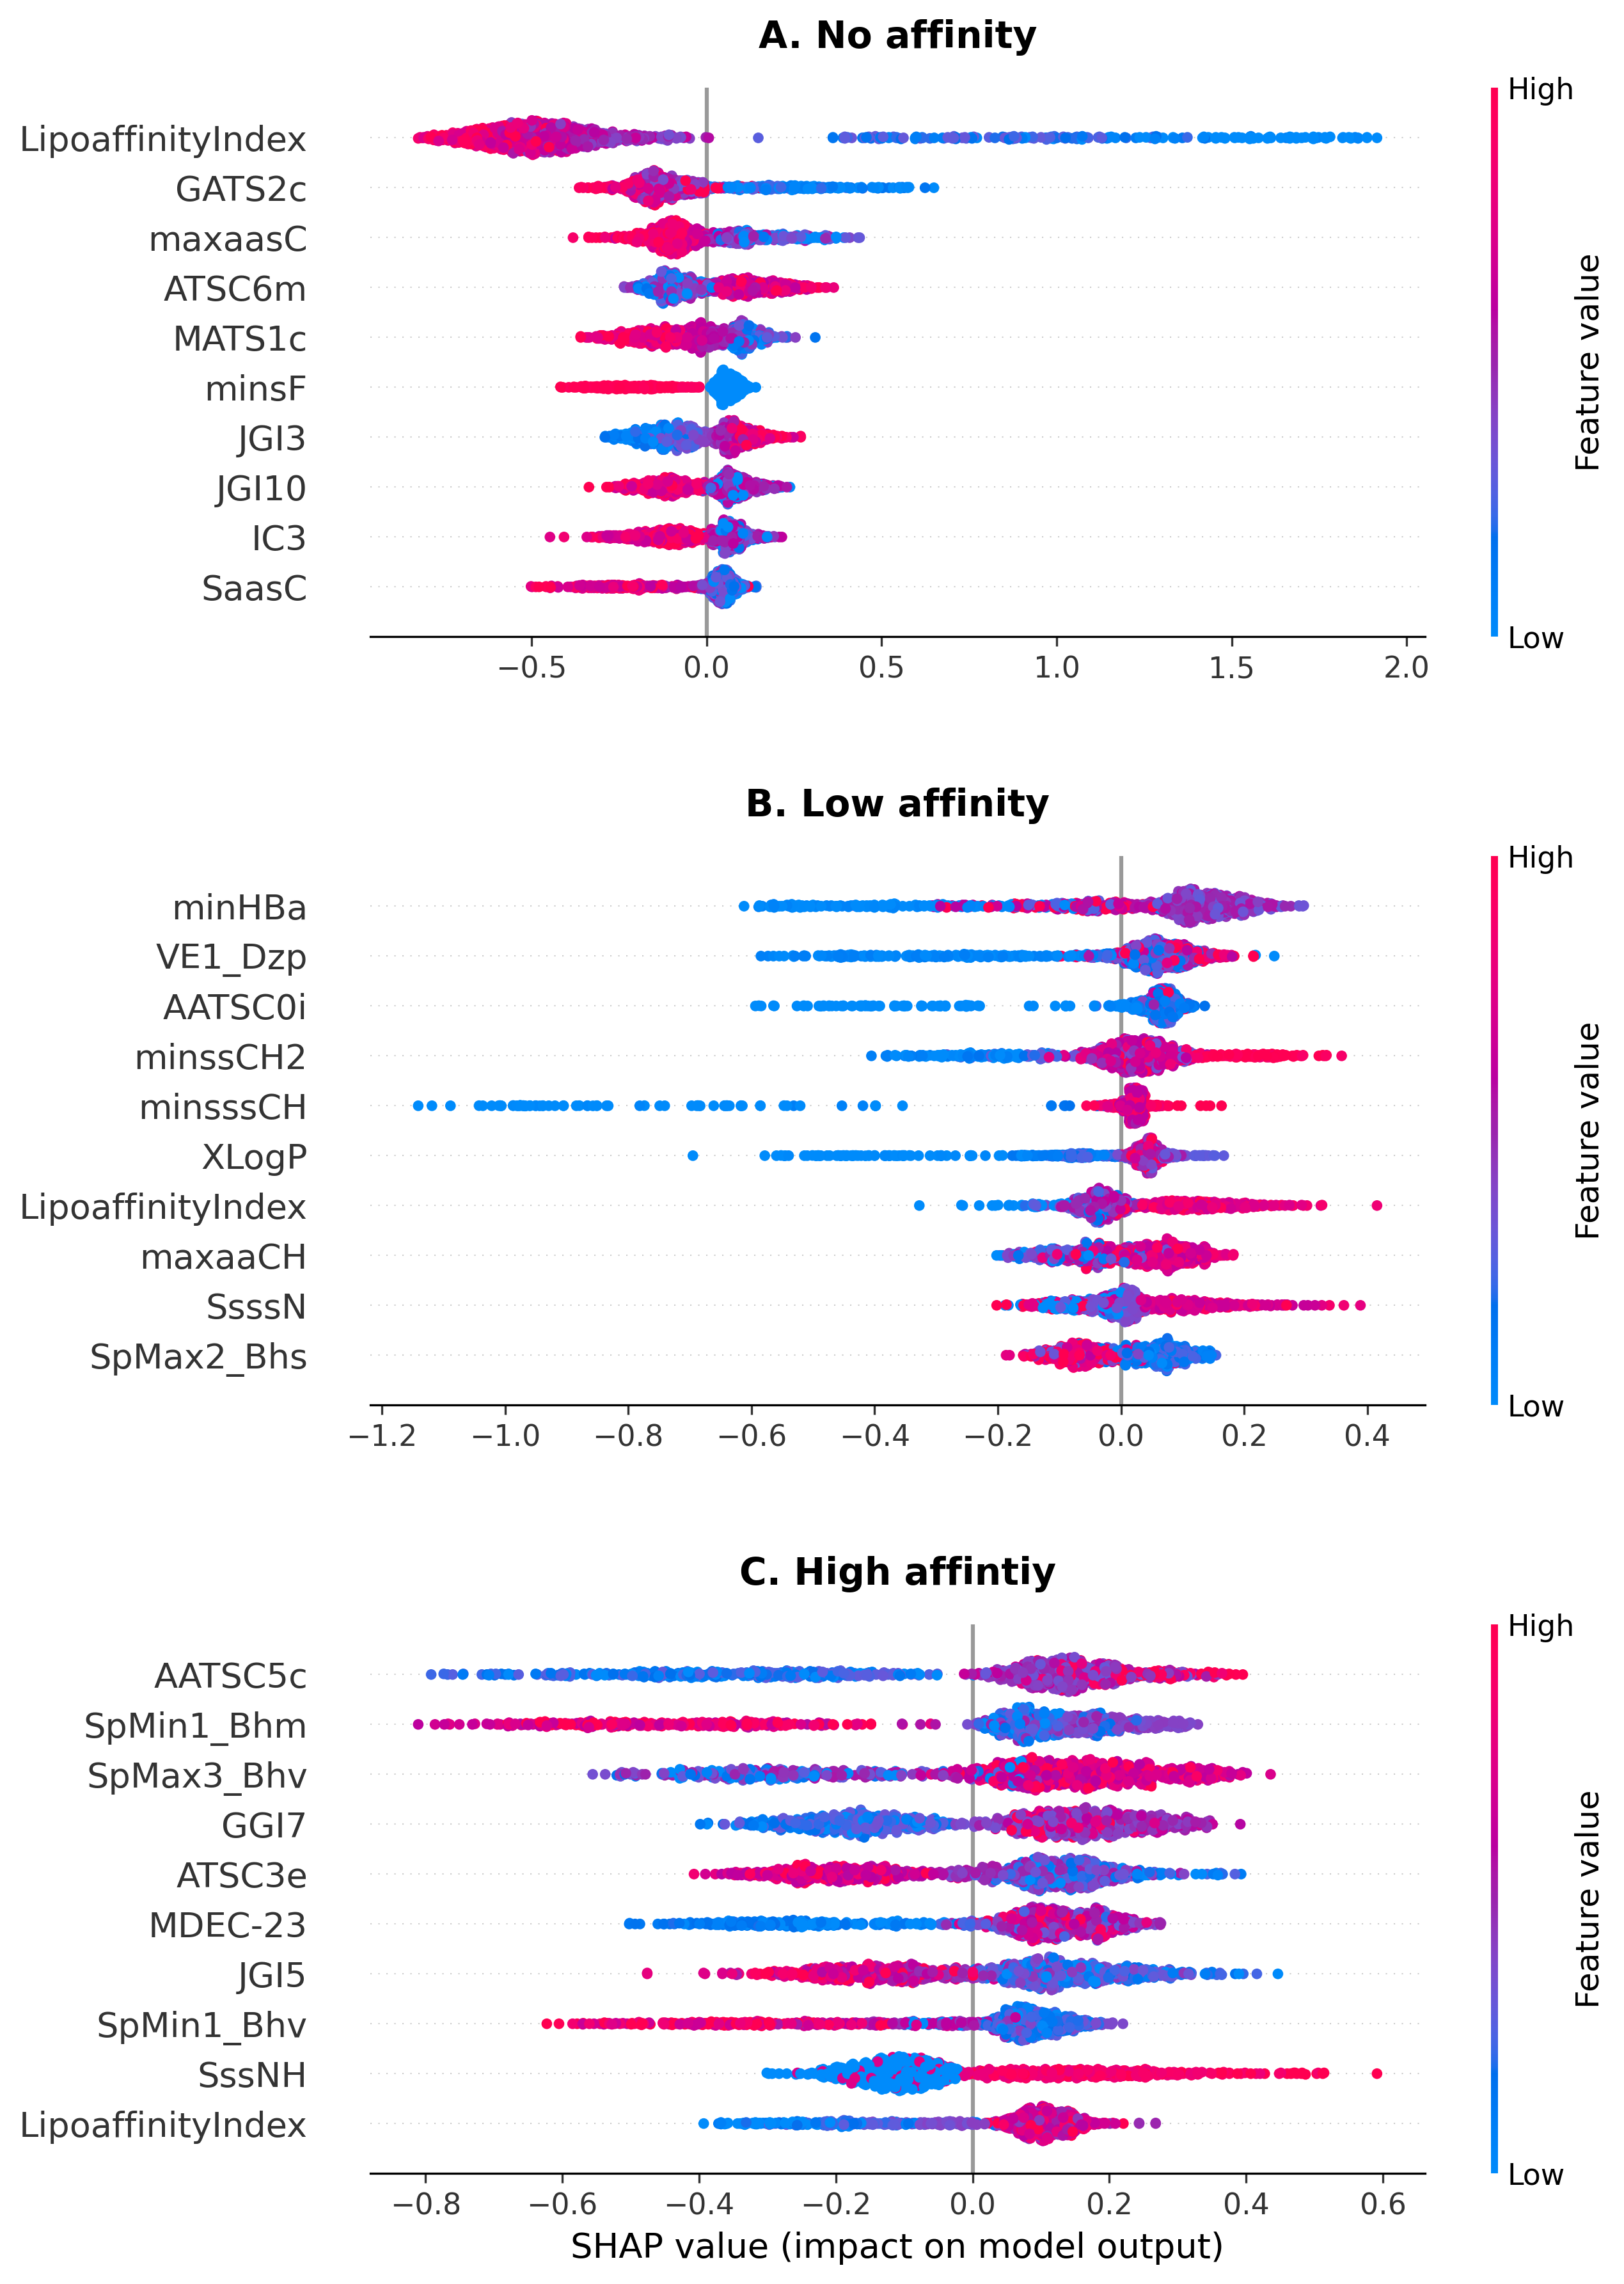

In [ ]:
shaps = [shap_values_class0, shap_values_class1, shap_values_class2]
titles = ["A. No affinity", "B. Low affinity", "C. High affintiy"]

fig, axes = plt.subplots(3, 1, figsize=(9, 12), dpi=300)

for i, (ax, expl, title) in enumerate(zip(axes, shaps, titles)):
    shap.plots.beeswarm(
        expl,
        max_display=10,
        group_remaining_features=False,
        show=False,
        plot_size=None,  
        ax=ax   
    )
    ax.set_title(title, loc="center", pad=15, fontweight="bold", fontsize=14)
    
    if i < len(axes) - 1:
        ax.set_xlabel("")  

plt.tight_layout()

plt.subplots_adjust(hspace=0.4)

# plt.savefig('beeswarm.png', bbox_inches='tight', dpi=300)

plt.show()

## Similarity mapping


In [ ]:
with open('model_ecfp_xgb_div.pkl', 'rb') as f:
    model_ecfp_xgb = pickle.load(f)

### XGBoost

### NPS


In [23]:
df_simis = pd.read_csv('ht2a_similarity_substances.csv', sep=";")

[08:39:39] DEPRECATION WARNING: please use MorganGenerator
[08:39:39] DEPRECATION WARNING: please use MorganGenerator


2.0
Serotonin


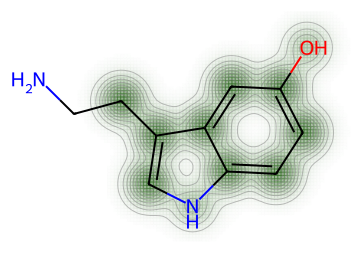

2.0


[08:39:39] DEPRECATION WARNING: please use MorganGenerator
[08:39:39] DEPRECATION WARNING: please use MorganGenerator


LSD


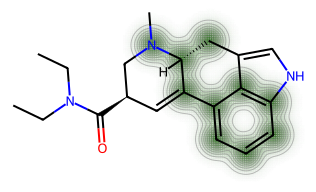

2.0


[08:39:39] DEPRECATION WARNING: please use MorganGenerator
[08:39:39] DEPRECATION WARNING: please use MorganGenerator


ALEPH-2


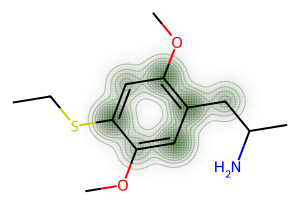

2.0


[08:39:39] DEPRECATION WARNING: please use MorganGenerator
[08:39:39] DEPRECATION WARNING: please use MorganGenerator


25iP-NBOMe


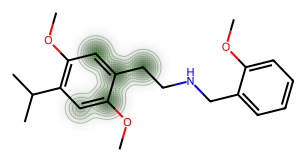

1.0


[08:39:40] DEPRECATION WARNING: please use MorganGenerator
[08:39:40] DEPRECATION WARNING: please use MorganGenerator


ALD-52


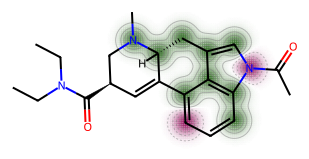

1.0
N,N-Dimethyltryptamine


[08:39:40] DEPRECATION WARNING: please use MorganGenerator
[08:39:40] DEPRECATION WARNING: please use MorganGenerator


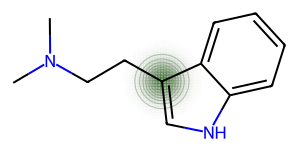

2.0


[08:39:40] DEPRECATION WARNING: please use MorganGenerator
[08:39:40] DEPRECATION WARNING: please use MorganGenerator


2C-B


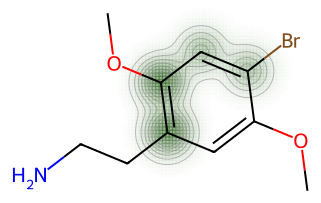

2.0


[08:39:41] DEPRECATION WARNING: please use MorganGenerator
[08:39:41] DEPRECATION WARNING: please use MorganGenerator


Bromo-Dragonfly


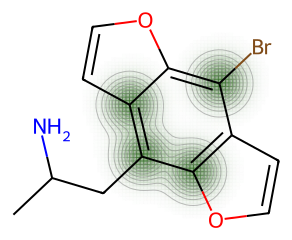

In [24]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

for smile, name in zip(df_simis["smiles"], df_simis["names"]):
    substance = Chem.MolFromSmiles(standardize_smiles(smile))
    print(single_prediction(substance, model_ecfp_xgb.predict))
    img = plot_similarity_map(substance, model_ecfp_xgb)  
    print(name)
    display(img)

#### Combined plot  

[08:39:41] DEPRECATION WARNING: please use MorganGenerator
[08:39:41] DEPRECATION WARNING: please use MorganGenerator
[08:39:41] DEPRECATION WARNING: please use MorganGenerator
[08:39:42] DEPRECATION WARNING: please use MorganGenerator
[08:39:42] DEPRECATION WARNING: please use MorganGenerator
[08:39:42] DEPRECATION WARNING: please use MorganGenerator
[08:39:43] DEPRECATION WARNING: please use MorganGenerator
[08:39:43] DEPRECATION WARNING: please use MorganGenerator


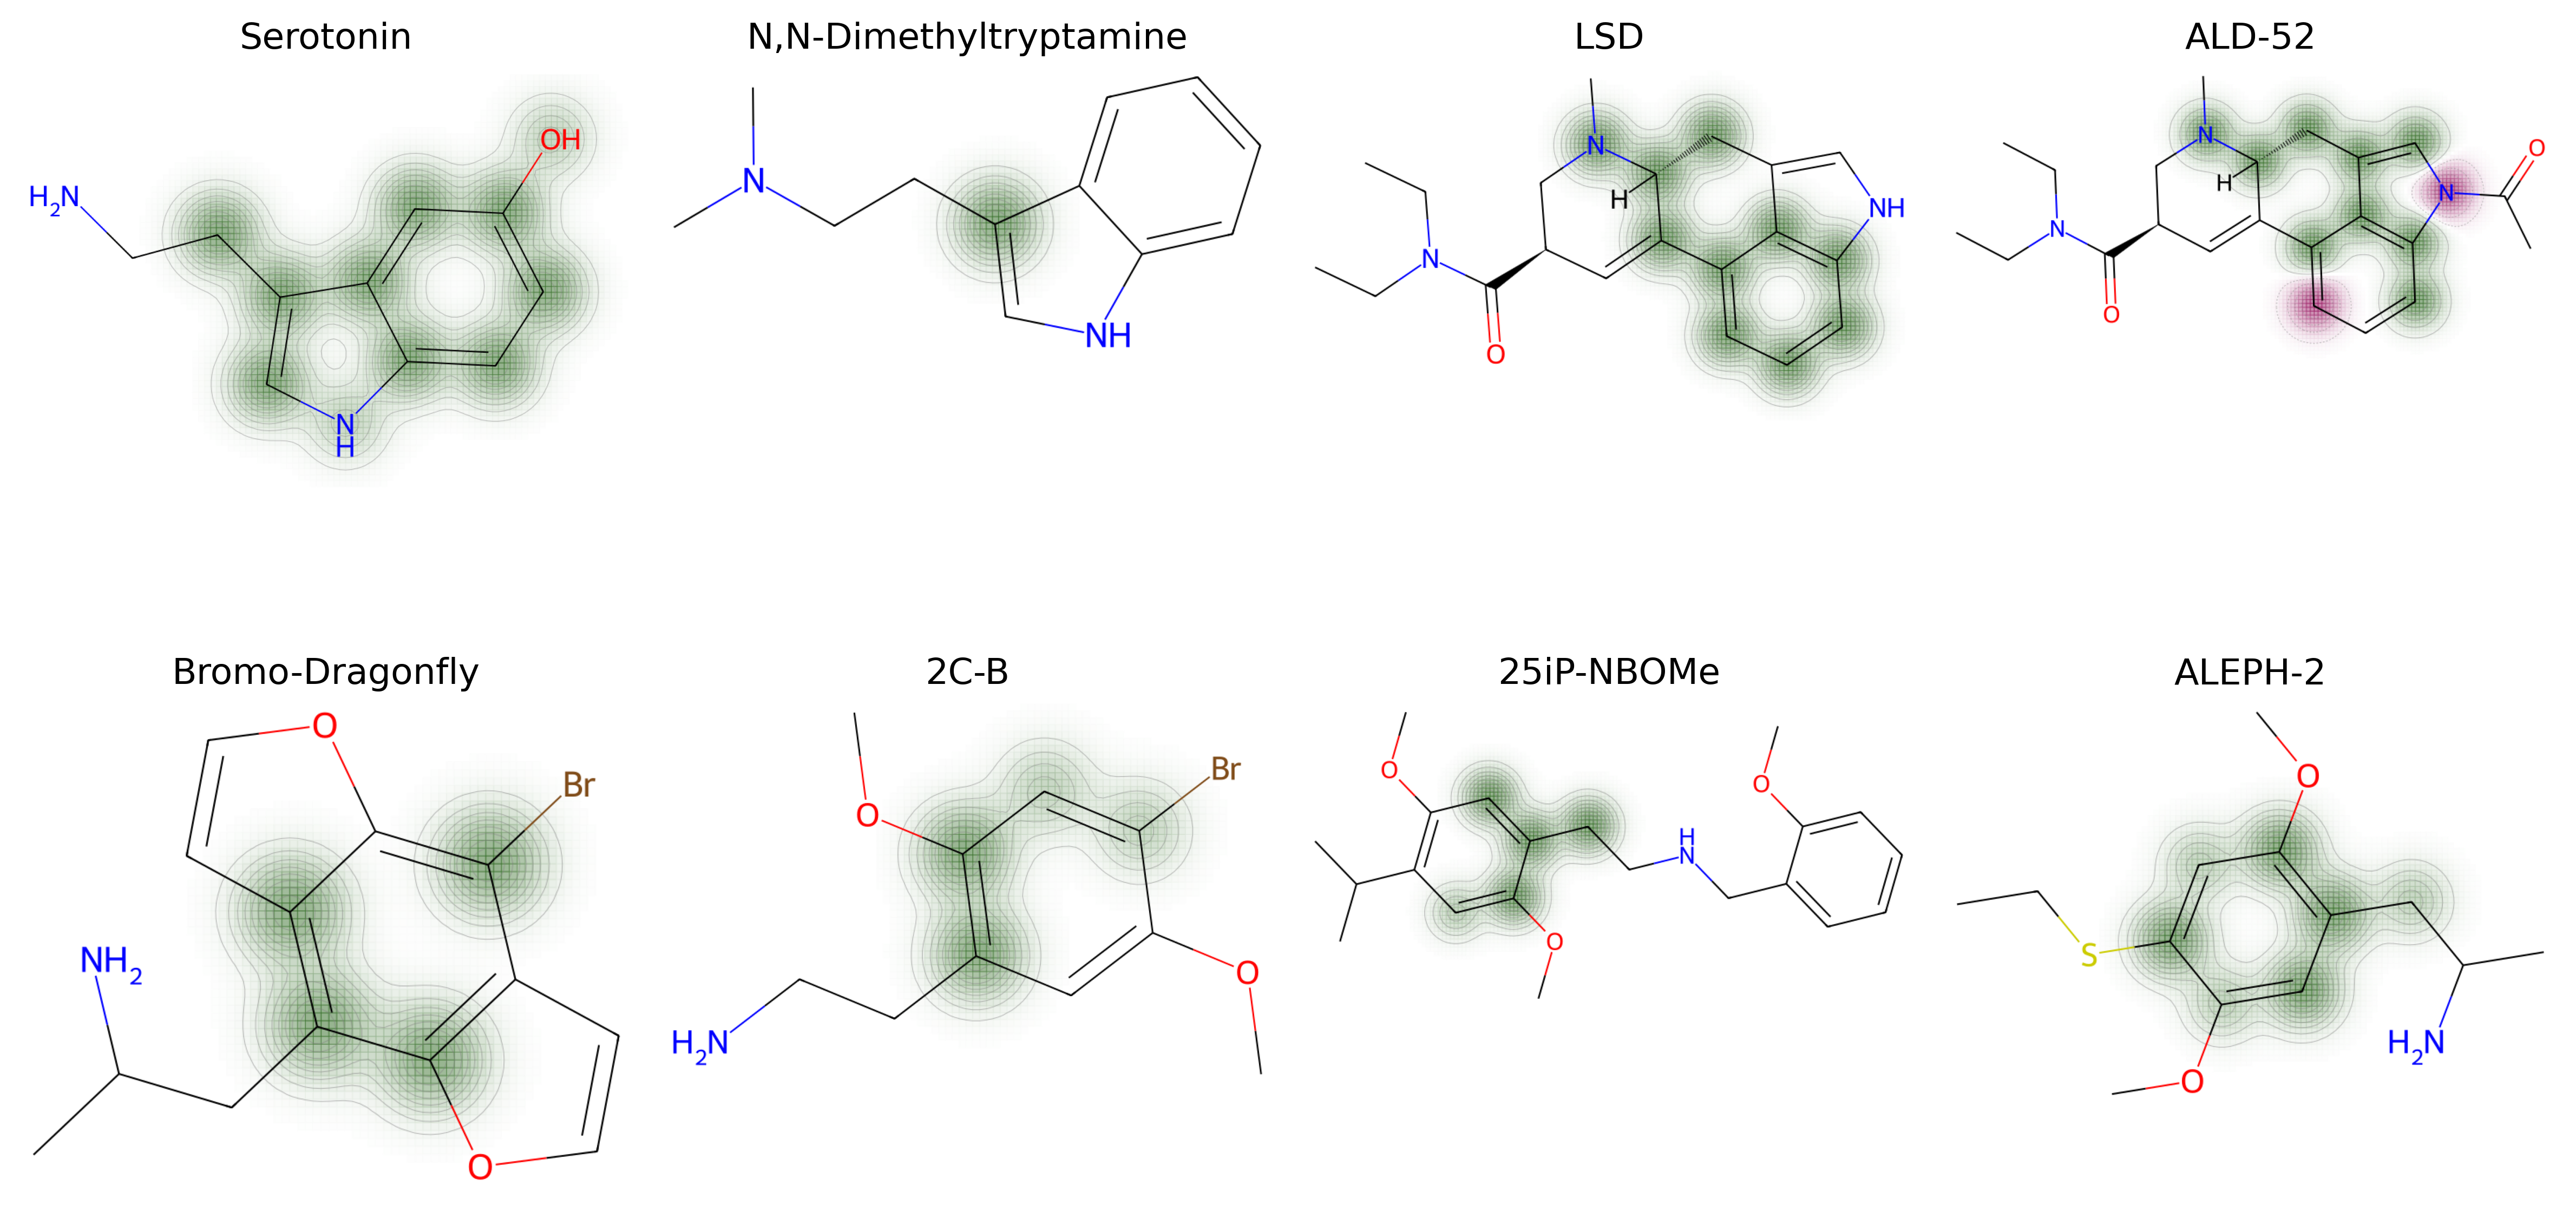

In [25]:

# make dict of molecules
mols = {name: Chem.MolFromSmiles(standardize_smiles(smile)) 
        for smile, name in zip(df_simis["smiles"], df_simis["names"])}

# sort
selected = ["Serotonin", "N,N-Dimethyltryptamine", "LSD", "ALD-52", "Bromo-Dragonfly", "2C-B", "25iP-NBOMe", "ALEPH-2"] # Psilocin ALD-52 Psilocybin

# generate images
imgs = [plot_similarity_map(mols[name], model_ecfp_xgb, size=(1000,1000)) for name in selected]

# subplot grid
fig, axes = plt.subplots(2, 4, figsize=(12, 7), dpi=400,)

axes = axes.ravel() 

if len(selected) == 1:
    axes = [axes]

for ax, img, name in zip(axes, imgs, selected):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(name, loc="center")
    ax.set_anchor("N")

plt.tight_layout()

# plt.savefig('NPS_SM_XGB.png', bbox_inches='tight', dpi=300)

plt.show()
